# Analysis of Toy Model Branching

## Import Packages

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import two_branch_CIFAR as tb_cifar
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from scipy.linalg import subspace_angles
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu



TwoBranchCNN_CIFAR(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (branch1_conv1): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
  (branch1_conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (branch1_conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (branch1_drop): Dropout2d(p=0.5, inplace=False)
  (branch1_fc1): Linear(in_features=2000, out_features=50, bias=True)
  (branch2_conv1): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
  (branch2_conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (branch2_conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (branch2_drop): Dropout2d(p=0.5, inplace=False)
  (branch2_fc1): Linear(in_features=2000, out_features=50, bias=True)
  (final_fc): Linear(in_features=100, out_features=10, bias=True)
)


In [3]:
# plot the data
sns.set_style(style='white')
dark_green = '#006400'
dark_red = '#8b0000'
pal = {'Trained Model': dark_green, 'Untrained Model': dark_red}
light_green = '#90ee90'
light_red = '#ffcccb'
face_palette = sns.color_palette([light_green, light_red])
boxprops = {'edgecolor': 'k', 'linewidth': 2}
lineprops = {'color': 'k', 'linewidth': 2}

## Load Model and Weights

In [4]:
# initialize the model architechture
model = tb_cifar.TwoBranchCNN_CIFAR()
untrained_model = tb_cifar.TwoBranchCNN_CIFAR()

# Load the weights into the model
model.load_state_dict(torch.load('model_weights_two_stream_CIFAR10.pth'))

# Switch to evaluation mode 
model.eval()
untrained_model.eval()

/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_5687/900164235.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights

TwoBranchCNN_CIFAR(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (branch1_conv1): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
  (branch1_conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (branch1_conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (branch1_drop): Dropout2d(p=0.5, inplace=False)
  (branch1_fc1): Linear(in_features=2000, out_features=50, bias=True)
  (branch2_conv1): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
  (branch2_conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (branch2_conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (branch2_drop): Dropout2d(p=0.5, inplace=False)
  (branch2_fc1): Linear(in_features=2000, out_features=50, bias=True)
  (final_fc): Linear(in_features=100, out_features=10, bias=True)
)

In [5]:
# visualize the filters in the first convolutional layer of branch 1 and 2
# Extract weights
branch1_conv1_weights = model.branch1_conv1.weight.data.clone()
branch2_conv1_weights = model.branch2_conv1.weight.data.clone()
# print shape of weights
print(branch1_conv1_weights.shape)
print(branch2_conv1_weights.shape)

# extract the weights from the untrained model
branch1_conv1_weights_untrained = untrained_model.branch1_conv1.weight.data.clone()
branch2_conv1_weights_untrained = untrained_model.branch2_conv1.weight.data.clone()

# print shape of weights
print(branch1_conv1_weights_untrained.shape)
print(branch2_conv1_weights_untrained.shape)

torch.Size([20, 20, 5, 5])
torch.Size([20, 20, 5, 5])
torch.Size([20, 20, 5, 5])
torch.Size([20, 20, 5, 5])


### Unfold weights

In [6]:
def unfold_weights(weight):
    out_channels, in_channels, kernel_height, kernel_width = weight.shape
    
    unfold = nn.Unfold(kernel_size=(kernel_height, kernel_width),
                       dilation=1,
                       padding=0,
                       stride=1)
    
    # Convert weight back to a PyTorch tensor if it's a NumPy array
    if isinstance(weight, np.ndarray):
        weight = torch.from_numpy(weight)
    
    # Reshape the weight tensor to (1, out_channels * in_channels, kernel_height, kernel_width)
    # weight_reshaped = weight.view(1, out_channels * in_channels, kernel_height, kernel_width)
    
    # Apply unfold
    unfolded = unfold(weight)
    unfolded = unfolded.view(out_channels, -1).cpu().numpy() 
    print(f'Unfolded shape: {unfolded.shape}')
    # Reshape the result
    return unfolded

In [7]:
# Unfold the weights
branch1_conv1_weights_unfolded = unfold_weights(branch1_conv1_weights)
branch2_conv1_weights_unfolded = unfold_weights(branch2_conv1_weights)

branch1_conv1_weights_flat = branch1_conv1_weights_unfolded
branch2_conv1_weights_flat = branch2_conv1_weights_unfolded

branch1_conv1_weights_untrained_unfolded = unfold_weights(branch1_conv1_weights_untrained)
branch2_conv1_weights_untrained_unfolded = unfold_weights(branch2_conv1_weights_untrained)
branch1_conv1_weights_untrained_flat = branch1_conv1_weights_untrained_unfolded
branch2_conv1_weights_untrained_flat = branch2_conv1_weights_untrained_unfolded


# print shapes of flattened weights
print(f'Branch 1 Conv1 Weights Shape: {branch1_conv1_weights_flat.shape}\n Branch 2 Conv1 Weights Shape: {branch2_conv1_weights_flat.shape}\n Branch 1 Conv1 Weights Untrained Shape: {branch1_conv1_weights_untrained_flat.shape}\n Branch 2 Conv1 Weights Untrained Shape: {branch2_conv1_weights_untrained_flat.shape}')

Unfolded shape: (20, 500)
Unfolded shape: (20, 500)
Unfolded shape: (20, 500)
Unfolded shape: (20, 500)
Branch 1 Conv1 Weights Shape: (20, 500)
 Branch 2 Conv1 Weights Shape: (20, 500)
 Branch 1 Conv1 Weights Untrained Shape: (20, 500)
 Branch 2 Conv1 Weights Untrained Shape: (20, 500)


## Compute SVD

In [8]:
# compute the subspace angles between the weights after SVD
U1, S1, V1 = np.linalg.svd(branch1_conv1_weights_flat, full_matrices=False)
U2, S2, V2 = np.linalg.svd(branch2_conv1_weights_flat, full_matrices=False)
V1 = V1.T
V2 = V2.T
# print shapes of SVD matrices
print(f'U1 Shape: {U1.shape} S1 Shape: {S1.shape} V1 Shape: {V1.shape}\n U2 Shape: {U2.shape} S2 Shape: {S2.shape} V2 Shape: {V2.shape}')

U1_untrained, S1_untrained, V1_untrained = np.linalg.svd(branch1_conv1_weights_untrained_flat, full_matrices=False)
U2_untrained, S2_untrained, V2_untrained = np.linalg.svd(branch2_conv1_weights_untrained_flat, full_matrices=False)
V1_untrained = V1_untrained.T
V2_untrained = V2_untrained.T
# print shapes of SVD matrices
print(f'U1 Untrained Shape: {U1_untrained.shape} S1 Untrained Shape: {S1_untrained.shape} V1 Untrained Shape: {V1_untrained.shape}\n U2 Untrained Shape: {U2_untrained.shape} S2 Untrained Shape: {S2_untrained.shape} V2 Untrained Shape: {V2_untrained.shape}')

U1 Shape: (20, 20) S1 Shape: (20,) V1 Shape: (500, 20)
 U2 Shape: (20, 20) S2 Shape: (20,) V2 Shape: (500, 20)
U1 Untrained Shape: (20, 20) S1 Untrained Shape: (20,) V1 Untrained Shape: (500, 20)
 U2 Untrained Shape: (20, 20) S2 Untrained Shape: (20,) V2 Untrained Shape: (500, 20)


In [9]:
# cumulative sum of the singular values for each 
explained_variance_ratio1 = np.cumsum(S1**2)/np.sum(S1**2)
print(f'Cumulative Explained Variance of 1st Trained Branch: {explained_variance_ratio1}')
explained_variance_ratio2 = np.cumsum(S2**2)/np.sum(S2**2)
print(f'Cumulative Explained Variance of 2nt Trained Branch: {explained_variance_ratio2}')

explained_variance_ratio1_untrained = np.cumsum(S1_untrained**2)/np.sum(S1_untrained**2)
print(f'Cumulative Explained Variance of 1st Untrained Branch: {explained_variance_ratio1_untrained}')
explained_variance_ratio2_untrained = np.cumsum(S2_untrained**2)/np.sum(S2_untrained**2)
print(f'Cumulative Explained Variance of 2nd Untrained Branch: {explained_variance_ratio2_untrained}')

Cumulative Explained Variance of 1st Trained Branch: [0.12099943 0.21783942 0.30098817 0.37730628 0.44726175 0.51391125
 0.57509744 0.6297642  0.68174785 0.73003393 0.7750217  0.815803
 0.8508551  0.8836616  0.9130402  0.9385021  0.9610429  0.9816605
 0.99379206 1.0000001 ]
Cumulative Explained Variance of 2nt Trained Branch: [0.12983762 0.23423441 0.32708135 0.41291788 0.4859762  0.5470698
 0.60336304 0.6528459  0.7001938  0.7439659  0.7850835  0.82165414
 0.8536934  0.88438857 0.91174763 0.93542236 0.9581565  0.97785276
 0.9942297  0.99999994]
Cumulative Explained Variance of 1st Untrained Branch: [0.06896193 0.13494505 0.19886653 0.25971973 0.31990218 0.3764656
 0.4326997  0.48857006 0.53915876 0.58855003 0.63621235 0.68241465
 0.72853756 0.77028054 0.81137    0.85227907 0.89229035 0.92961484
 0.9653767  0.99999994]
Cumulative Explained Variance of 2nd Untrained Branch: [0.06797419 0.13343368 0.19638903 0.25804964 0.3185799  0.37519678
 0.43015912 0.48404974 0.5351588  0.5848984  0.

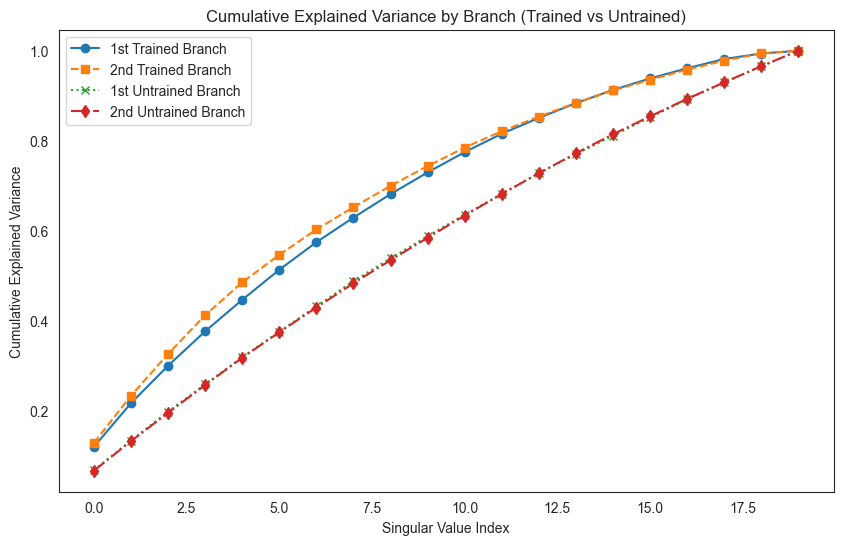

In [10]:
# Plot cumulative explained variance for trained branches
plt.figure(figsize=(10, 6))

# Plot for the 1st trained branch
plt.plot(explained_variance_ratio1, label='1st Trained Branch', linestyle='-', marker='o')

# Plot for the 2nd trained branch
plt.plot(explained_variance_ratio2, label='2nd Trained Branch', linestyle='--', marker='s')

# Plot cumulative explained variance for untrained branches
# Plot for the 1st untrained branch
plt.plot(explained_variance_ratio1_untrained, label='1st Untrained Branch', linestyle=':', marker='x')

# Plot for the 2nd untrained branch
plt.plot(explained_variance_ratio2_untrained, label='2nd Untrained Branch', linestyle='-.', marker='d')

# Add labels and title
plt.xlabel('Singular Value Index')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Branch (Trained vs Untrained)')
plt.legend()

# Show the plot
plt.show()

## Compute Subspace Angles

In [11]:
# get subspace angles between the two V matrices
# print shapes of the V matrices
print(f'V1 Shape: {V1.shape} V2 Shape: {V2.shape}')
print(f'V1 Untrained Shape: {V1_untrained.shape} V2 Untrained Shape: {V2_untrained.shape}')
angles = np.degrees(subspace_angles(V1, V2))
untrained_angles = np.degrees(subspace_angles(V1_untrained, V2_untrained))
# V1 trained subspace
V1_trained_subspace = V1[:, :10]
# V2 trained subspace
V2_trained_subspace = V2[:, :10]
# V1 untrained subspace
V1_untrained_subspace = V1_untrained[:, :10]
# V2 untrained subspace
V2_untrained_subspace = V2_untrained[:, :10]
subspace_angles_trained = np.degrees(subspace_angles(V1_trained_subspace, V2_trained_subspace))
subspace_angles_untrained = np.degrees(subspace_angles(V1_untrained_subspace, V2_untrained_subspace))


V1 Shape: (500, 20) V2 Shape: (500, 20)
V1 Untrained Shape: (500, 20) V2 Untrained Shape: (500, 20)


Length of angles: 20,
 Angles: [89.494095 88.29877  87.081245 85.04581  84.075035 79.28092  76.76173
 75.31688  73.817375 71.69897  68.451836 66.897835 66.048294 64.55505
 61.037067 57.061344 55.946564 51.31251  48.542137 41.172646]
Length of untrained angles: 20
Untrained Angles: [89.902214 88.18905  86.91892  86.36712  85.58683  85.11865  84.55925
 83.495865 82.780716 81.97716  80.909485 79.104614 77.802734 77.66001
 75.21569  74.28569  71.2256   70.443825 70.243164 68.367584]


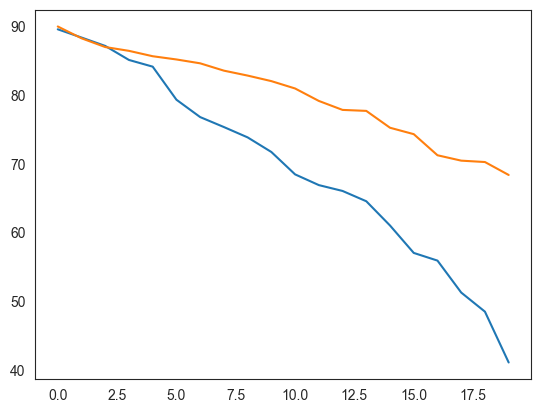

In [12]:
# plot angles as line plot
fig, ax = plt.subplots()
x = np.arange(len(angles))
ax.plot(x, angles, label='Trained Model')
ax.plot(x, untrained_angles, label='Untrained Model')
# print the angles
print(f'Length of angles: {len(angles)},\n Angles: {angles}')
print(f'Length of untrained angles: {len(untrained_angles)}\nUntrained Angles: {untrained_angles}')

In [13]:
# Function to test normality and compare angles
def test_normality_and_compare(trained_angles, untrained_angles):
    # Test for normality
    stat_trained, p_trained = shapiro(trained_angles)
    stat_untrained, p_untrained = shapiro(untrained_angles)
    
    if p_trained > 0.05 and p_untrained > 0.05:
        # Both datasets are normally distributed
        t_stat, p_value = ttest_ind(trained_angles, untrained_angles, equal_var=False)
        test_name = "Welch's t-test"
    else:
        # At least one dataset is not normally distributed
        u_stat, p_value = mannwhitneyu(trained_angles, untrained_angles)
        test_name = "Mann-Whitney U test"
    
    return test_name, p_value

## Function to add statistical annotations
def add_stat_annotation(ax, x1, x2, y, text):
    h = y + (0.1*y)  # Adjust line_height as needed
    y_line = y + .3  # Adjust line_offset as needed
    ax.plot([x1, x1, x2, x2], [y_line, h, h, y_line], lw=1.5, color='k')
    ax.text((x1 + x2) * 0.5, h, text, ha='center', va='bottom', color='k')

/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_5687/1772034452.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Trained Model', 'Untrained Model'], fontsize=12, fontweight='bold')
/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_5687/1772034452.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Model', y='Angles', data=df, jitter=0.2, ax=ax, **stripplotkwargs)


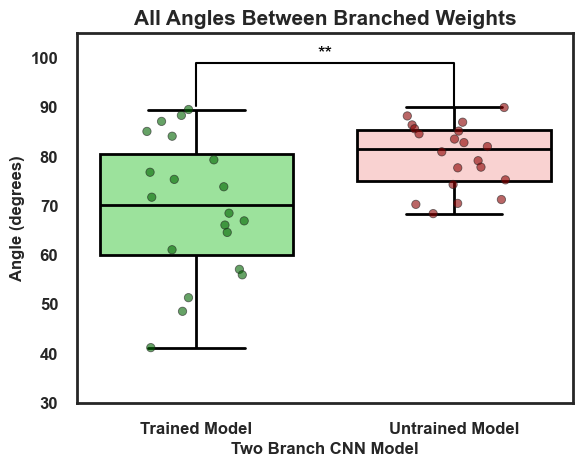

In [14]:
# create a dataframe
df = pd.DataFrame({'Angles': np.concatenate([angles, untrained_angles]), 'Model': ['Trained Model'] * len(angles) + ['Untrained Model'] * len(untrained_angles)})


hue_order = ['Trained Model', 'Untrained Model']

boxplotkwargs = {'boxprops': boxprops, 'medianprops': lineprops,
                 'whiskerprops': lineprops, 'capprops': lineprops,
                 'width': 0.75, 'palette': face_palette,
                 'hue_order': hue_order}

stripplotkwargs = {'linewidth': 0.6, 'size': 6, 'alpha': 0.6,
                    'palette': pal, 'hue_order': hue_order}

# Increase font size and thickness of axes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 2,
    'xtick.major.width': 2.5,
    'ytick.major.width': 2.5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'xtick.major.size': 10,
    'ytick.major.size': 10,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
})

fig, ax = plt.subplots()
# choose color palette
sns.set_palette("tab10")
sns.boxplot(x='Model', y='Angles', hue='Model', data=df, ax=ax, fliersize=0, **boxplotkwargs)
plt.yticks(fontweight='bold')
# label the axes
ax.set_ylabel('Angle (degrees)', fontsize=12, fontweight='bold')
ax.set_title('All Angles Between Branched Weights', fontsize=15, fontweight='bold')
ax.set_xticklabels(['Trained Model', 'Untrained Model'], fontsize=12, fontweight='bold')
ax.set_xlabel('Two Branch CNN Model', fontsize=12, fontweight='bold')
plt.ylim(30, 105)
# remove grey background
sns.stripplot(x='Model', y='Angles', data=df, jitter=0.2, ax=ax, **stripplotkwargs)
# Add statistical annotations
test_name, p_value = test_normality_and_compare(angles, untrained_angles)
if p_value <= 0.0001:
    annotation = '****'
elif p_value <= 0.001:
    annotation = '***'
elif p_value <= 0.01:
    annotation = '**'
elif p_value <= 0.05:
    annotation = '*'
else:
    annotation = 'ns'

# Find the y-position for the annotation
y_max = df['Angles'].max()
add_stat_annotation(ax, 0, 1, y_max, annotation)
# make boxes narrower

plt.show()



/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_5687/2072279692.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Trained Model', 'Untrained Model'], fontsize=12, fontweight='bold')
/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_5687/2072279692.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Model', y='Angles', data=df, jitter=0.2, ax=ax, **stripplotkwargs)


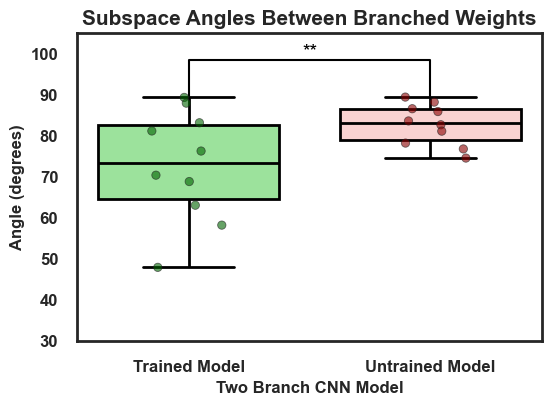

In [16]:
# create a dataframe
df = pd.DataFrame({'Angles': np.concatenate([subspace_angles_trained, subspace_angles_untrained]), 'Model': ['Trained Model'] * len(subspace_angles_trained) + ['Untrained Model'] * len(subspace_angles_untrained)})


hue_order = ['Trained Model', 'Untrained Model']

boxplotkwargs = {'boxprops': boxprops, 'medianprops': lineprops,
                 'whiskerprops': lineprops, 'capprops': lineprops,
                 'width': 0.75, 'palette': face_palette,
                 'hue_order': hue_order}

stripplotkwargs = {'linewidth': 0.6, 'size': 6, 'alpha': 0.6,
                    'palette': pal, 'hue_order': hue_order}

# Increase font size and thickness of axes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 2,
    'xtick.major.width': 2.5,
    'ytick.major.width': 2.5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'xtick.major.size': 10,
    'ytick.major.size': 10,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
})

fig, ax = plt.subplots()
# set figure size
fig.set_size_inches(6, 4)
# choose color palette
sns.set_palette("tab10")
sns.boxplot(x='Model', y='Angles', hue='Model', data=df, ax=ax, fliersize=0, **boxplotkwargs)
plt.yticks(fontweight='bold')
# label the axes
ax.set_ylabel('Angle (degrees)', fontsize=12, fontweight='bold')
ax.set_title('Subspace Angles Between Branched Weights', fontsize=15, fontweight='bold')
ax.set_xticklabels(['Trained Model', 'Untrained Model'], fontsize=12, fontweight='bold')
ax.set_xlabel('Two Branch CNN Model', fontsize=12, fontweight='bold')
plt.ylim(30, 105)
# remove grey background
sns.stripplot(x='Model', y='Angles', data=df, jitter=0.2, ax=ax, **stripplotkwargs)
# Add statistical annotations
test_name, p_value = test_normality_and_compare(angles, untrained_angles)
if p_value <= 0.0001:
    annotation = '****'
elif p_value <= 0.001:
    annotation = '***'
elif p_value <= 0.01:
    annotation = '**'
elif p_value <= 0.05:
    annotation = '*'
else:
    annotation = 'ns'

# Find the y-position for the annotation
y_max = df['Angles'].max()
add_stat_annotation(ax, 0, 1, y_max, annotation)

# save figure
folder = "/Volumes/Extreme SSD/Allen SU24/Figures"
filename = "toy_model_subspace_angles"
plt.savefig(f'{folder}/{filename}.png', dpi=300, bbox_inches='tight')

plt.show()
